In [1]:
# importar os pacotes necess�rios
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

rand = 40

#Importando os dados
df = pd.read_csv(r"/content/DatasetAntigo.csv")

#Imprimindos a dimensão das linhas e variáveis da base de dados
print("Quantidade de dados: ", df.shape[0])
print("Quantidade de variáveis: ", df.shape[1])

#Imprimindo as 5 primeiras linhas
df.head()



Quantidade de dados:  159
Quantidade de variáveis:  8


,Cedente,Valor carteira,% Cart,Classificação,OBS,OBS das operações,Ramo de Atuação,Sugestão
0,HAROLDO V,203.529,"0,05",1,concentracao_pequena_sacados,cedente_pf_possui_pj,prestador_servicos,NaN
1,IVALDO MO,190.709,"0,04",0,concentracao_nome_proprio,concentracao_titulos_proprios,agropecuaria,Solicitar emissão de nota fiscal das vendas de...
2,SOLARSEEL,169.031,"0,04",1,parentesco_sacados,concentracao_titulos_proprios,prestador_servicos,NaN
3,MAURO DON,164.934,"0,04",1,parentesco_sacados,cedente_pf_possui_pj,comercio,NaN
4,NEW PRINC,163.948,"0,04",0,parentesco_sacados,concentracao_titulos_proprios,confeccao,Possibilidade de adequação com taxas menores


In [2]:
def Map_Var_DF (features, df):
  #Criando um dicion�rio para receber as vari�veis
  dict_var = {"feature": [],
              "Tipo": [],
              "Categórico": [],
              "Binário": [],
              "Qtd var unico": [],
              "Min": [],
              "Max": [],
              "% Qtd de Nulos": []}

  #Criando um loop a partir das features
  for feature in features:

    #Armazenando o nome da feature
    dict_var['feature'].append(feature)

    #Armazenando o tipo da vari�vel
    dict_var['Tipo'].append(df[feature].dtypes)

    #Armazenando a quantidade de valores nulos
    dict_var['% Qtd de Nulos'].append(round(df[feature].isnull().sum() / df.shape[0],4))

    if ((df[feature].dtype == "O")):

      #Atribuindo o valor 1 se a vari�vel for categ�rica
      dict_var['Categórico'].append(1)

      #Armazenando a quantidade de valores �nicos
      dict_var['Qtd var unico'].append(df[feature].nunique())

      #Armazenando os valores m�nimos
      dict_var['Min'].append("N/A")

      #Armazenando os valores m�ximos
      dict_var['Max'].append("N/A")

      if (df[feature].nunique() == 2):

        #Atribuindo o valor 1 se a vari�vel for bin�ria
        dict_var['Binário'].append(1)
        
      else:

        #Atribuindo o valor 0 se a vari�vel n�o for bin�ria
        dict_var['Binário'].append(0)

    else:

      #Atribuindo o valor 0 se a vari�vel n�o for categ�rica
      dict_var['Categórico'].append(0)

      #Armazenando a quantidade de valores �nicos
      dict_var['Qtd var unico'].append(df[feature].nunique())

      #Atribuindo o valor 0 se a vari�vel n�o for bin�ria
      dict_var['Binário'].append(0)

      #Armazenando os valores m�nimos
      dict_var['Min'].append(df[feature].min())

      #Armazenando os valores m�ximos
      dict_var['Max'].append(df[feature].max())
      
  #Transformando o dicion�rio em dataframe
  df_var = pd.DataFrame.from_dict(data = dict_var)

  #Imprimindo o dataframe
  return df_var

#Armazenando as features
features = df.columns.to_list()

#Armazenando as informa��es das vari�veis
df_var = Map_Var_DF(features = features, df = df)

#Imprimindo o dataframe
df_var


,feature,Tipo,Categórico,Binário,Qtd var unico,Min,Max,% Qtd de Nulos
0,Cedente,object,1,0,159,N/A,N/A,0.0000
1,Valor carteira,float64,0,0,152,0.0,899.706,0.0000
2,% Cart,object,1,0,68,N/A,N/A,0.0000
3,Classificação,int64,0,0,3,0,2,0.0000
4,OBS,object,1,0,8,N/A,N/A,0.0000
5,OBS das operações,object,1,0,8,N/A,N/A,0.0000
6,Ramo de Atuação,object,1,0,7,N/A,N/A,0.0000
7,Sugestão,object,1,0,37,N/A,N/A,0.7296


In [3]:

#Copiando o dataset
df_clean = df.copy()

#Exluindo os valores ausentes da vari�vel alvo
df_clean.dropna(subset = ['Classificação'] ,inplace = True)

#Armazenando as vari�veis a serem exclu�das
Col_Ex = ['Sugestão']

#Exluindo as colunas do dataframe
df_clean.drop(labels = Col_Ex, axis = 1, inplace = True)

#Armazenando as features do dataframe
features_clean = df_clean.columns.to_list()

#Replicando a fun��o
var_df_clean = Map_Var_DF(features = features_clean, df = df_clean)

#Imprimindo o datafram
var_df_clean



,feature,Tipo,Categórico,Binário,Qtd var unico,Min,Max,% Qtd de Nulos
0,Cedente,object,1,0,159,N/A,N/A,0.0
1,Valor carteira,float64,0,0,152,0.0,899.706,0.0
2,% Cart,object,1,0,68,N/A,N/A,0.0
3,Classificação,int64,0,0,3,0,2,0.0
4,OBS,object,1,0,8,N/A,N/A,0.0
5,OBS das operações,object,1,0,8,N/A,N/A,0.0
6,Ramo de Atuação,object,1,0,7,N/A,N/A,0.0


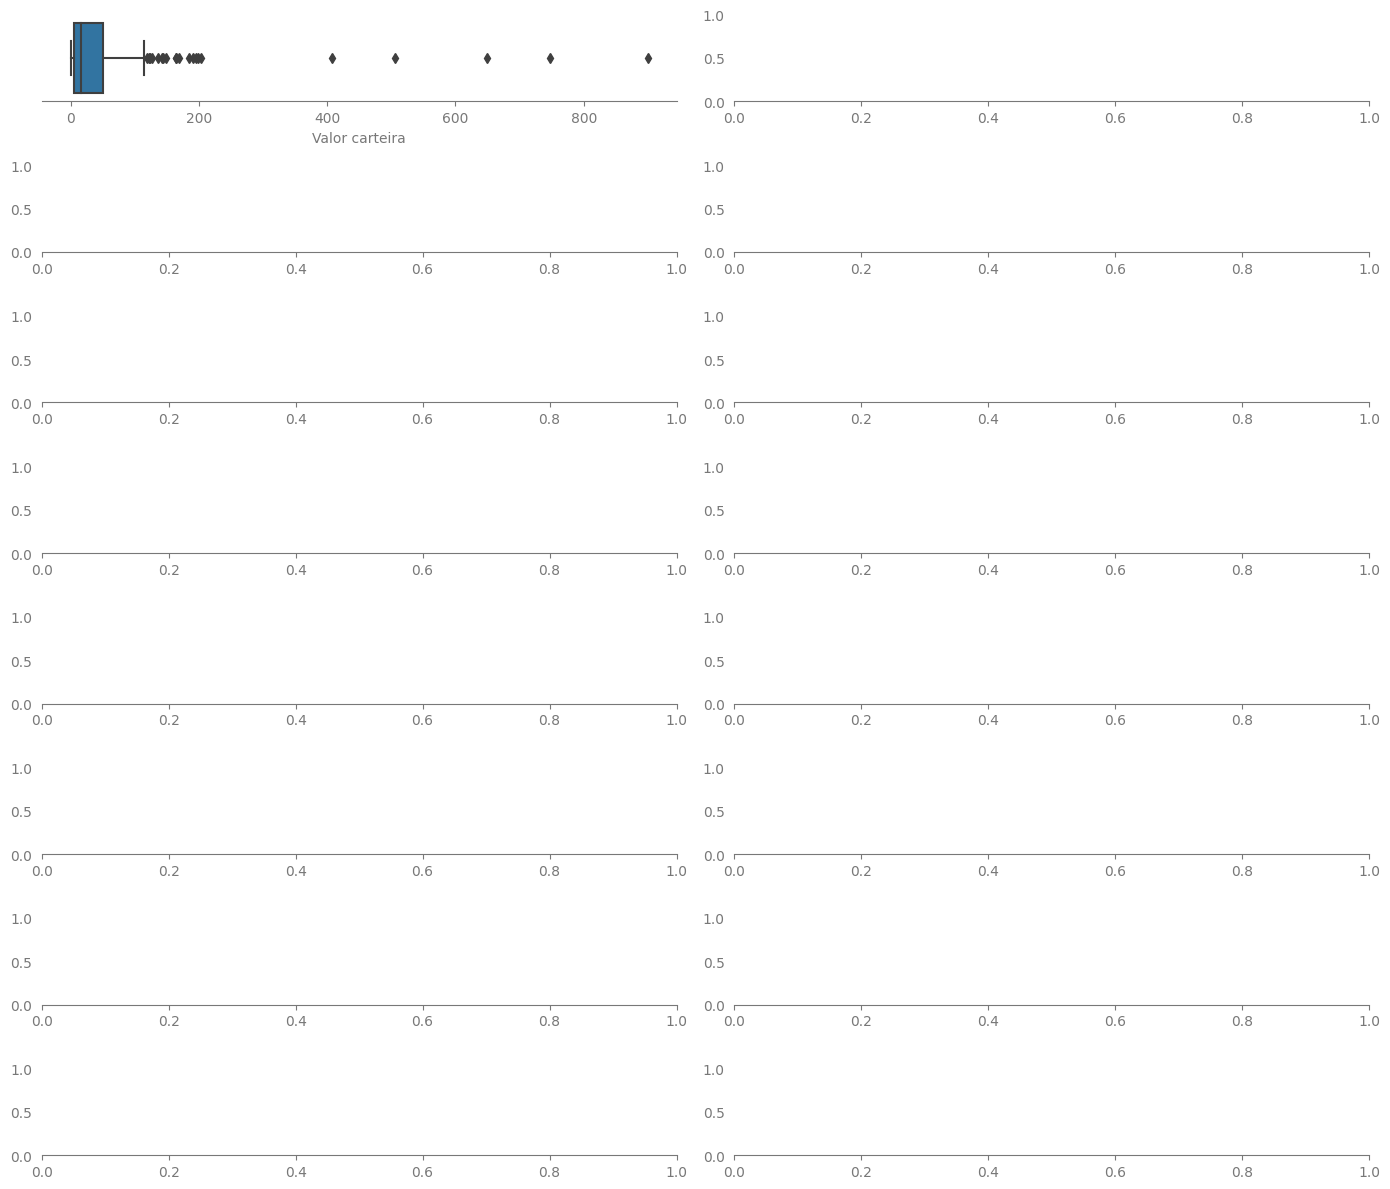

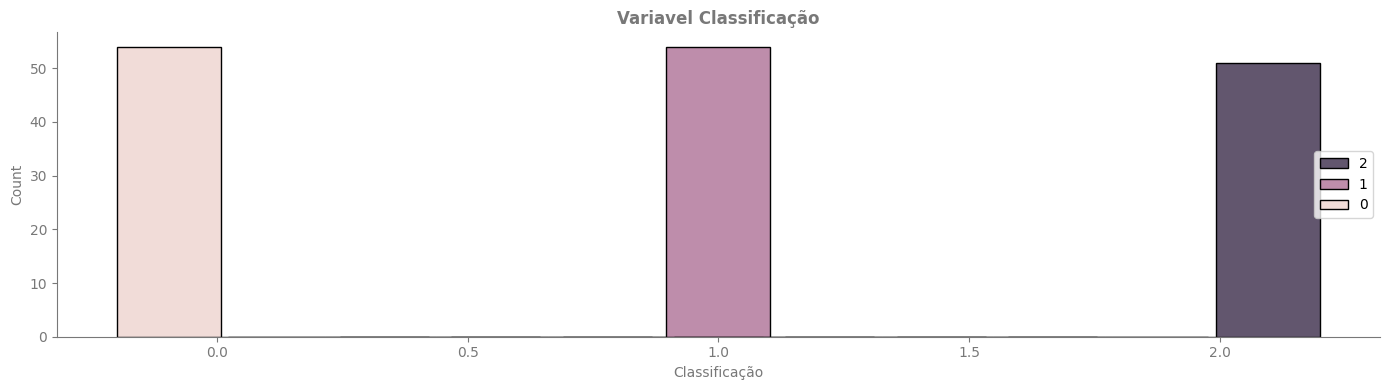

In [4]:
#Armazenando as features num�ricas
num_feature = var_df_clean['feature'].loc[ (var_df_clean['Tipo'] == 'float64') ].to_list()

#Contador
cont_x = 0
cont_y = 0

# #Definindo os par�metros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False,
             'axes.spines.left': False, 
             'ytick.left': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os par�metros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #Instanciando a figure e axes
  fig, ax = plt.subplots(nrows = 8, ncols = 2, figsize = (14,12) )

  #Rodando loop entre as features num�ricas
  for feature in num_feature:

    #Criando o Box Plot para as features
    sns.boxplot(x = feature, data = df_clean, ax = ax[cont_x,cont_y])

    #Atualizando os valores dos contadores para o axes
    if cont_y == 1:
      cont_x = cont_x + 1
      cont_y = 0

    else :
      cont_y = cont_y + 1

  #Imprimindo os gr�ficos
  fig.tight_layout()

#Definindo os par�metros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os par�metros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #Instanciando o objeto figure e axes
  fig, ax = plt.subplots( figsize = (14,4) )

  #Criando um histograma para a vari�vel tenure
  sns.histplot(data = df_clean, x = 'Classificação', ax = ax, hue = "Classificação", multiple="dodge", shrink=2.8)
    
    #Armazena o % da amostra
  percentual_default = round((df_clean['Classificação'].value_counts()[1] / df_clean.shape[0])*100,3)

  #Setando o t�tulo do gr�fico
  ax.set_title("Variavel Classificação")

  plt.legend(['2','1','0'],loc = 5)
  #Exibindo o gr�fico
  plt.tight_layout()



In [ ]:
#Lista de vari�veis num�ricas
var_num = ['Valor carteira', 
           '% Cart',
           'Classificação']

#Lista de vari�veis categ�ricas (getdummies)
var_cat = ['OBS', 
           'OBS das operações', 
           'Ramo de Atuação']
     
  #Vamos copiar o dataframe
df_trat = df_clean.copy()


#Aplicando o get_dummies nas vari�veis categ�ricas
df_trat = pd.get_dummies(data = df_trat, columns = var_cat)

#Imprimindo as 5 primeiras linhas
df_trat.head()


In [ ]:
#Definindo os valores de X e y
X = df_trat.drop(['Classificação','Cedente', '% Cart'], axis = 1)
y = df_trat['Classificação']

#Dividindo o dataset em treino e test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle = True, 
                                                    stratify = y,
                                                    random_state = rand)

# #Instanciando os parametros do Kfold para Validaçao Cruzada
# k_fold = KFold(n_splits = 5, shuffle = True, random_state = rand)

X_train 


,Valor carteira,OBS_boa_distribuicao_sacados,OBS_cedente_pf,OBS_cnpj_recente,OBS_concentracao_nome_proprio,OBS_concentracao_pequena_sacados,OBS_muitos_titulos_vencidos,OBS_parentesco_sacados,OBS_sem_operacoes_ativas,OBS das operações_alta_concentracao,...,OBS das operações_concentracao_titulos_proprios,OBS das operações_concentracao_titulos_vencidos,OBS das operações_nenhum_registro,Ramo de Atuação_agropecuaria,Ramo de Atuação_comercio,Ramo de Atuação_confeccao,Ramo de Atuação_industria,Ramo de Atuação_prestador_servicos,Ramo de Atuação_saude,Ramo de Atuação_varejo
20,49.542,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
146,144.058,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
29,27.764,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
49,11.400,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
103,3.780,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,136.513,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
73,2.500,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
119,59.056,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
64,4.050,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
X_test

,Valor carteira,OBS_boa_distribuicao_sacados,OBS_cedente_pf,OBS_cnpj_recente,OBS_concentracao_nome_proprio,OBS_concentracao_pequena_sacados,OBS_muitos_titulos_vencidos,OBS_parentesco_sacados,OBS_sem_operacoes_ativas,OBS das operações_alta_concentracao,...,OBS das operações_concentracao_titulos_proprios,OBS das operações_concentracao_titulos_vencidos,OBS das operações_nenhum_registro,Ramo de Atuação_agropecuaria,Ramo de Atuação_comercio,Ramo de Atuação_confeccao,Ramo de Atuação_industria,Ramo de Atuação_prestador_servicos,Ramo de Atuação_saude,Ramo de Atuação_varejo
111,198.530,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
41,16.731,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
148,0.000,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
45,12.346,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
88,19.700,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
11,110.492,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,163.948,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
142,4.450,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
153,14.000,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
30,26.826,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
y_test

111    2
41     0
148    2
45     1
88     2
11     1
4      0
142    0
153    0
30     0
138    2
21     1
52     0
89     0
113    0
54     1
90     1
18     2
145    2
75     0
48     0
51     2
156    0
16     2
74     1
0      1
99     0
47     2
136    1
79     2
154    2
55     1
42     1
129    1
141    2
117    1
100    0
127    2
149    0
69     1
Name: Classificação, dtype: int64

In [ ]:
from sklearn.feature_selection import SelectFromModel

model_rl = LogisticRegression(random_state = rand)

#Treinando o modelo
model_rl.fit(X = X_train, y = y_train)

#Calculando a probabilidade y
y_proba = model_rl.predict_proba(X_test)

#Transformando em um dataframe
y_proba_df = pd.DataFrame(y_proba)


#df.apply(lambda row: row['First']*row['Second']* row['Third'], axis=1)
y_proba_df['Predict'] = y_proba_df.apply(lambda row: 0 if row[0] > 0.333 else 1 if row[1] > 0.333 else 2.0, axis=1)

y_proba_df



,0,1,2,Predict
0,0.176646,0.076273,0.747081,2.0
1,0.417076,0.373479,0.209445,0.0
2,0.095192,0.079418,0.825390,2.0
3,0.087208,0.143547,0.769244,2.0
4,0.333551,0.511812,0.154637,0.0
5,0.312399,0.532279,0.155322,1.0
6,0.568523,0.295516,0.135961,0.0
7,0.803013,0.056215,0.140772,0.0
8,0.363248,0.142951,0.493801,0.0
9,0.291046,0.293763,0.415191,2.0


              precision    recall  f1-score   support

           0       0.55      0.79      0.65        14
           1       0.67      0.62      0.64        13
           2       0.62      0.38      0.48        13

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.59        40
weighted avg       0.61      0.60      0.59        40

--------------------------------------------------------------------


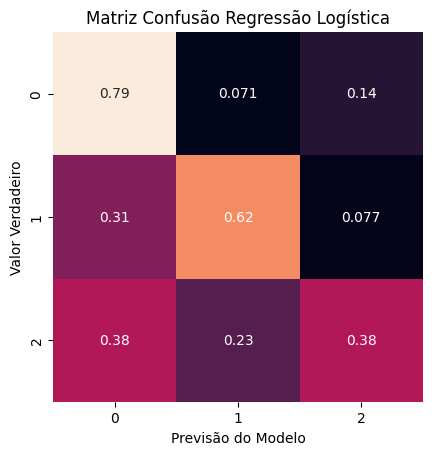

In [ ]:
# Classification Report
print(classification_report(y_test, y_proba_df['Predict']))

#print("AUC Score: ",roc_auc_score(y_test, y_proba[:,1]))

print("--------------------------------------------------------------------")

#Instanciando a figure e axes
fig, ax = plt.subplots()

#Plotando a matriz de confusão em um heatmap
sns.heatmap(confusion_matrix(y_test, y_proba_df['Predict'], normalize = 'true'), 
            square=True, 
            annot=True, 
            cbar=False,
            ax = ax)

#Definindo o nome do eixo x
ax.set_xlabel("Previsão do Modelo")

#Definindo o nome do eixo y
ax.set_ylabel("Valor Verdadeiro")

#Definindo o título
ax.set_title("Matriz Confusão Regressão Logística")

#Exibindo a matriz de confusão
plt.show()